# Exercise 6: Dimensionality Reduction & Performance Evaluation

In [1]:
# Load packages we need
import sys
import os

import numpy as np
import sklearn

import scipy as sp

import tensorflow as tf

# we'll use keras for neural networks
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 20})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('------------')


# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots

2024-02-23 08:28:42.229446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 08:28:42.810198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Python version: 3.8.0 (default, Dec  9 2021, 17:53:27) 
[GCC 8.4.0]
### Numpy version: 1.24.3
### Scikit-learn version: 1.3.2
------------


In [2]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.

seed = 42 # deterministic seed

np.random.seed(seed) 

prop_vec = [24, 2, 2]

## Let's do some clustering on synthetic data

In [3]:
from sklearn.datasets import make_blobs

# generate data using sklearn's make blobs
centroids = [[1, 1], [-1, -0.5], [1, -1], [-2, 3]]
num_clusters = len(centroids)
X, true_labels = make_blobs(n_samples=300, centers=centroids, cluster_std=0.5)




def plot_clustering(title, X, clustering_labels, clustering_centroids, 
                    num_clusters = 4, colors = ['blue', 'green', 'magenta', 'orange', 'red']):

    assert len(colors) >= num_clusters

    fig = plt.figure(figsize=(13, 10))
    plt.title(title)

    ax = fig.gca()
    for i, colv in zip(range(num_clusters), colors):
        cluster_members = clustering_labels == i
        cluster_centeroid = clustering_centroids[i]
        ax.plot(X[cluster_members, 0], X[cluster_members, 1], 'w', markerfacecolor=colv,  markeredgecolor='k', marker='.', markersize=16, alpha=0.5)
        ax.plot(cluster_centeroid[0], cluster_centeroid[1], '^', markerfacecolor=colv, markeredgecolor='k', markersize=22)
        
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())

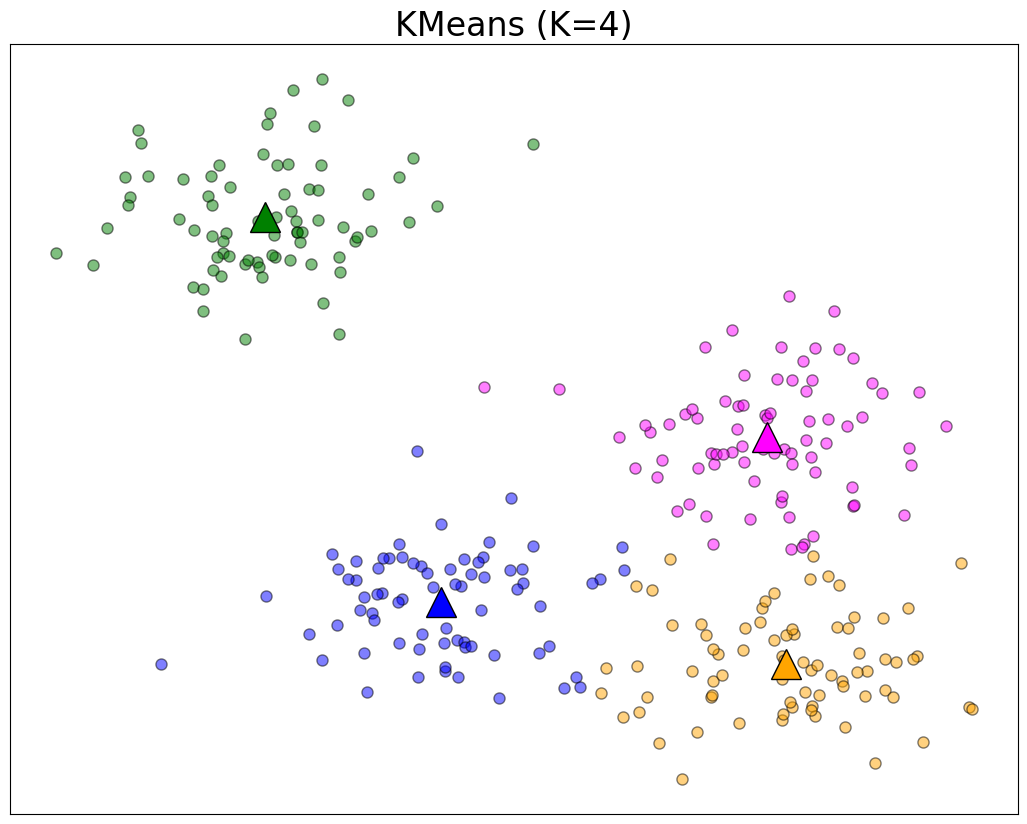

In [4]:
from sklearn.cluster import KMeans

# KMeans clustering
k = 4
kmeans = KMeans(n_clusters=k, n_init='auto').fit(X) # note: we fit only on X

cluster_centroids = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

plot_clustering('KMeans (K={})'.format(k), X, cluster_labels, cluster_centroids, num_clusters=k)

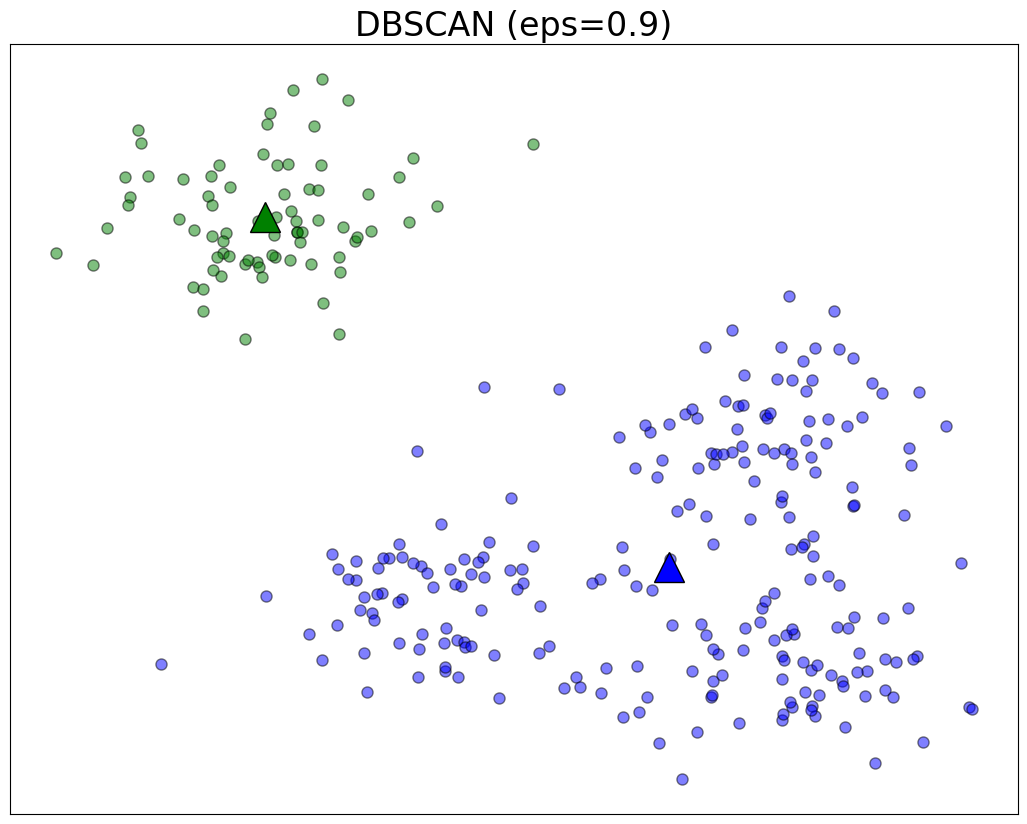

In [5]:
from sklearn.cluster import DBSCAN

# DBSCAN clustering
eps=0.9
dbscan = DBSCAN(eps=eps).fit(X)

cluster_labels = dbscan.labels_
assert np.amin(cluster_labels) > -1

# need to compute cluster centroids
unique_labels = np.unique(cluster_labels)
num_clusters = unique_labels.shape[0]
cluster_centroids = np.zeros((num_clusters, 2))

for i, lab in enumerate(unique_labels):
    idx = np.where(cluster_labels == lab)[0]
    cluster_centroids[i, :] = np.mean(X[idx,:], axis=0)

plot_clustering('DBSCAN (eps={})'.format(eps), X, cluster_labels, cluster_centroids, num_clusters=num_clusters)

### Loading the MNIST dataset

In [6]:
"""
## Load and preprocess the MNIST dataset
"""
def load_preprocess_mnist_data(flatten=True, onehot=True, prop_vec=[26, 2, 2], seed=None, verbose=False):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if verbose:
        # MNIST has overall shape (60000, 28, 28) -- 60k images, each is 28x28 pixels
        print('Loaded MNIST data; shape: {} [y: {}], test shape: {} [y: {}]'.format(x_train.shape, y_train.shape,
                                                                                      x_test.shape, y_test.shape))
    
    if flatten:
        # Let's flatten the images for easier processing (labels don't change)
        flat_vector_size = 28 * 28
        x_train = x_train.reshape(x_train.shape[0], flat_vector_size)
        x_test = x_test.reshape(x_test.shape[0], flat_vector_size)

    if onehot:
        # Put the labels in "one-hot" encoding using keras' to_categorical()
        num_classes = 10
        y_train = tf.keras.utils.to_categorical(y_train, num_classes)
        y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    # let's aggregate all the data then split
    all_x = np.r_[x_train, x_test]
    all_y = np.r_[y_train, y_test]
    
    # split the data into train, test, val
    train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(all_x, all_y, prop_vec, shuffle=True, seed=seed)
    return train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y

In [7]:
# grab the data
train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y = load_preprocess_mnist_data(onehot=False, prop_vec=prop_vec, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((60000, 784), (60000,), (5000, 784), (5000,), (5000, 784), (5000,))

### Let's look at the data

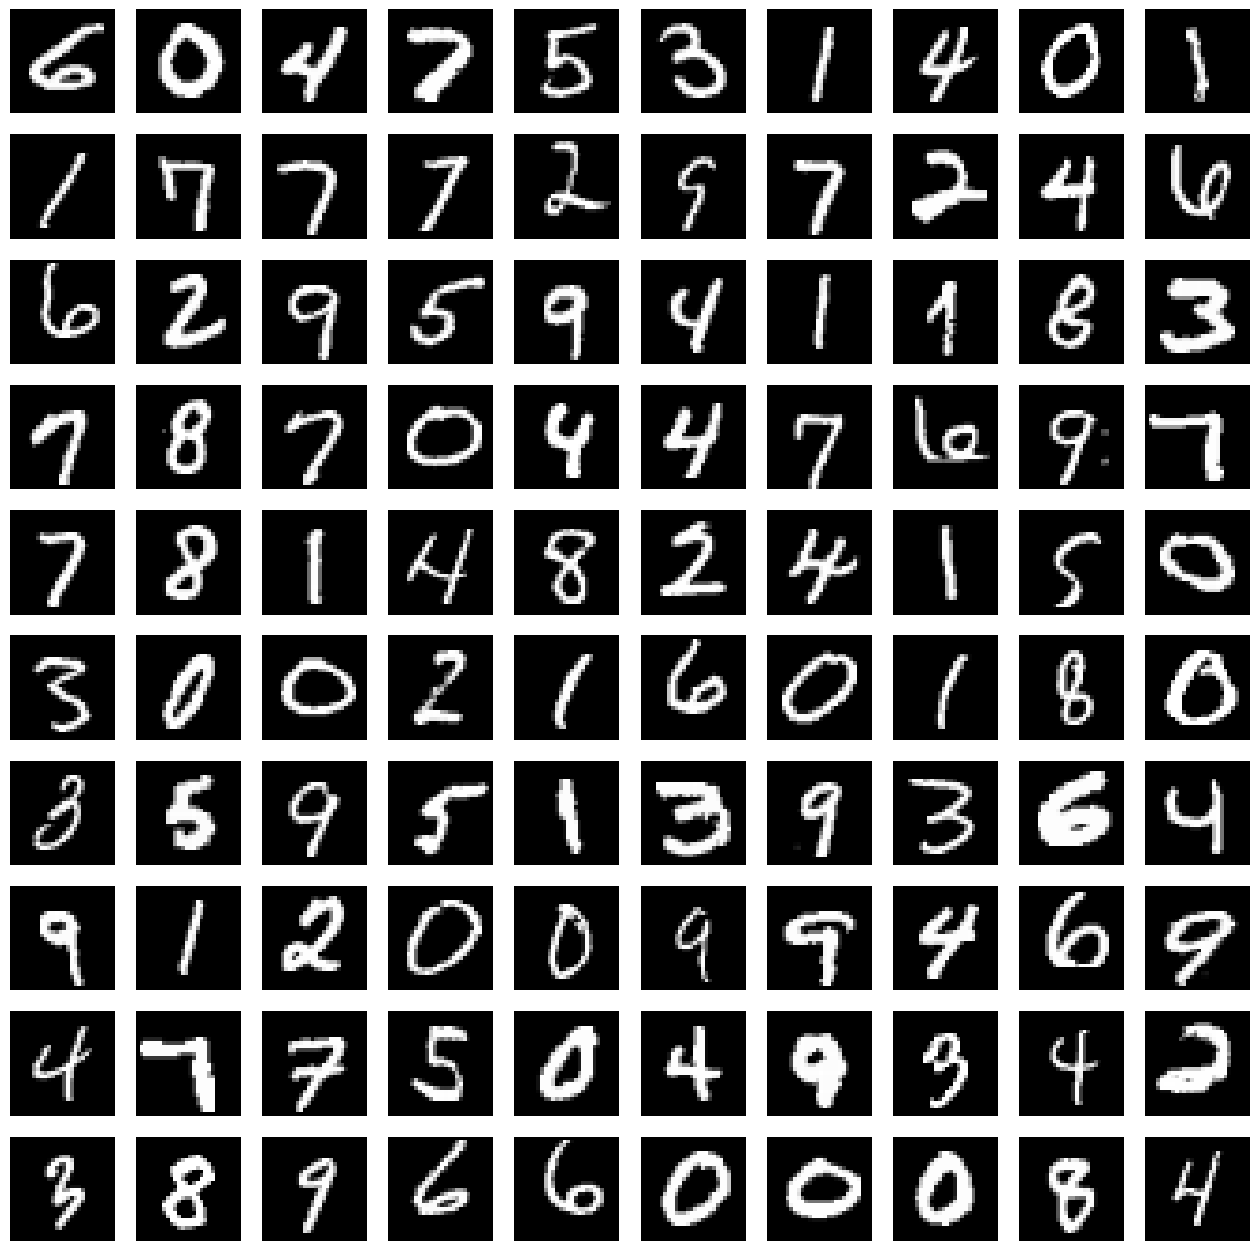

In [8]:
plots.plot_images(train_x[0:100].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(16,16))

### Can we reduce the dimension of MNIST?

In [9]:
# adjusted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

def plot_embedding(orig, X, y, fig_size=(16,16), min_plot_digit_dist=2e-2):

    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=fig_size)
    ax = plt.subplot(111)
    
    # plot the digit for each data point (as opposed to some marker)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(y[i] / 9.), fontdict={'weight': 'bold', 'size': 12})

    
    from matplotlib import offsetbox
    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]]) 
        
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_plot_digit_dist: # only plot images if not too close
                continue
                
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(orig[i], cmap=plt.cm.gray_r), X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])

### What happens if we use TSNE on the MNIST data?

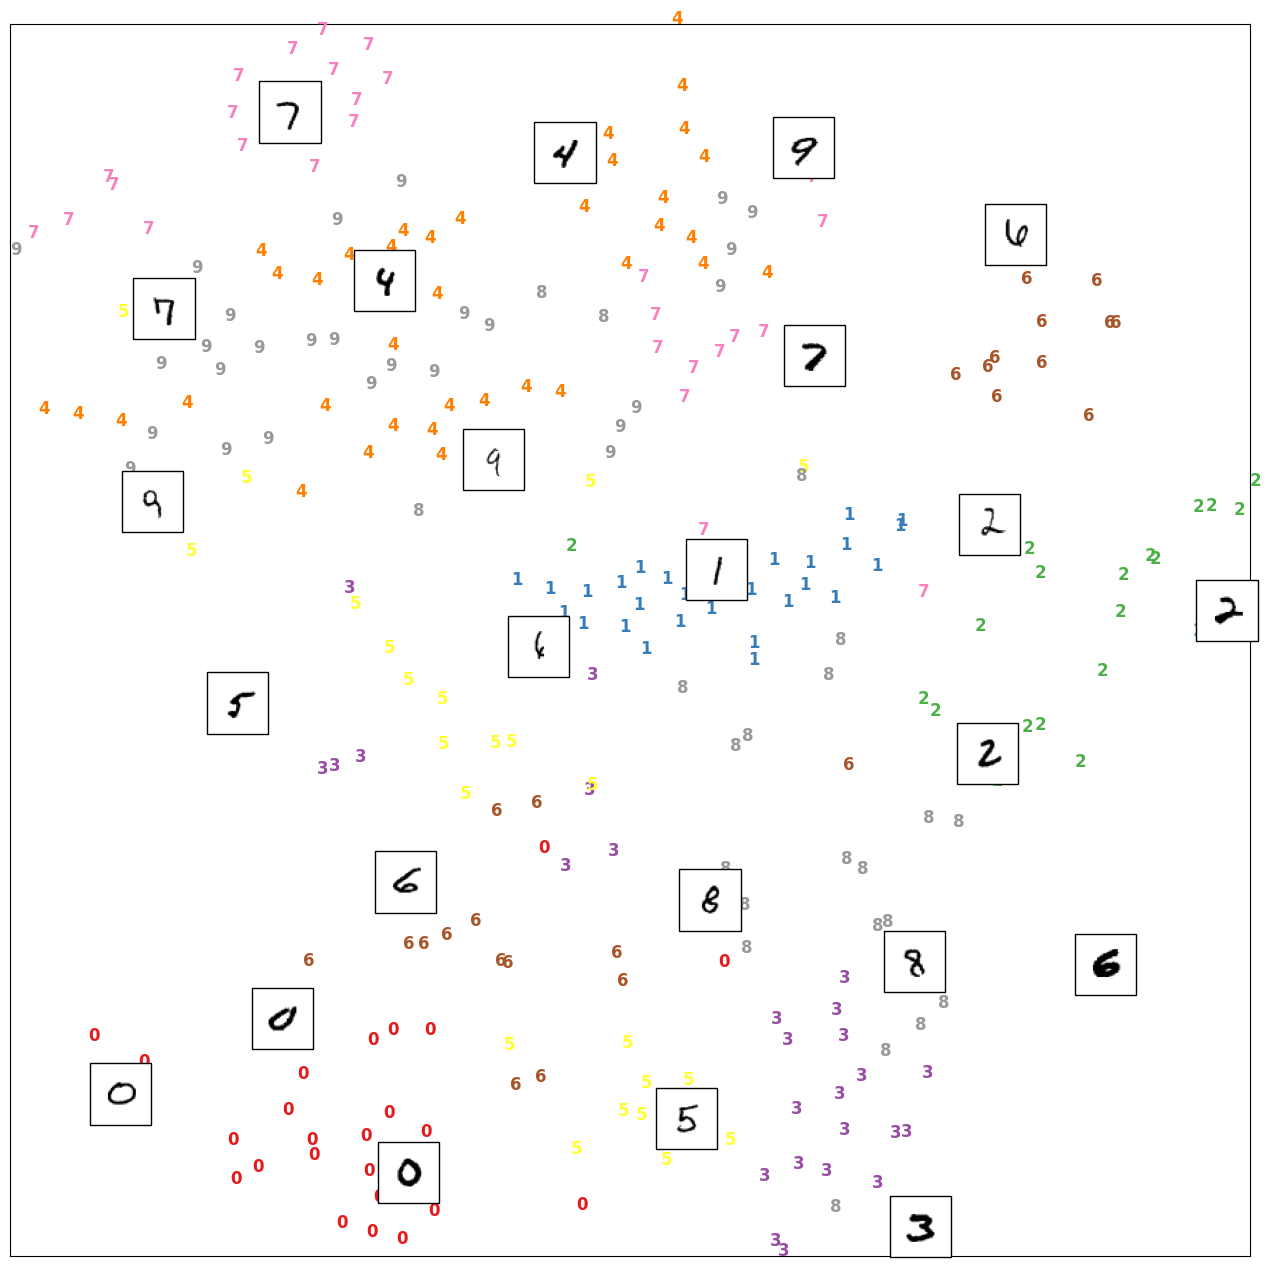

In [10]:
from sklearn.manifold import TSNE

tr_sz = 300

tsne = TSNE(n_components=2, init='pca', random_state=seed)
X_tsne = tsne.fit_transform(train_x[0:tr_sz])

plot_embedding(train_x[0:tr_sz].reshape(-1, 28, 28), X_tsne, train_y[0:tr_sz])

## Let's train a logistic regression model

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=20).fit(train_x, train_y)

/home/vbindsch/venv/cai41046108mle/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Let's look at the confusion matrix

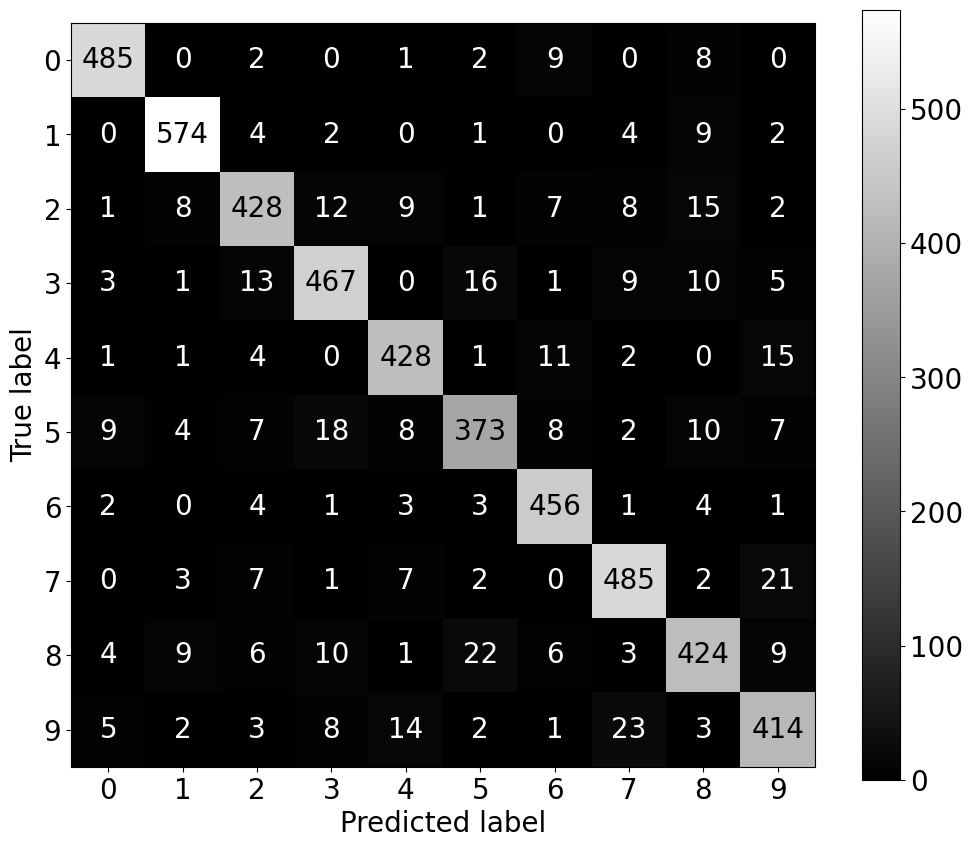

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# predictions
pred_y  = model.predict(val_x)
cm = confusion_matrix(val_y, pred_y)

fig = plt.figure(figsize=(12,10))
ax = plt.gca()
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cmdisp.plot(ax=ax, cmap='gray')
plt.show()

In [13]:
print(classification_report(val_y, pred_y, digits=2))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       507
           1       0.95      0.96      0.96       596
           2       0.90      0.87      0.88       491
           3       0.90      0.89      0.89       525
           4       0.91      0.92      0.92       463
           5       0.88      0.84      0.86       446
           6       0.91      0.96      0.94       475
           7       0.90      0.92      0.91       528
           8       0.87      0.86      0.87       494
           9       0.87      0.87      0.87       475

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.90      5000
weighted avg       0.91      0.91      0.91      5000



### Error analysis: Let's sort the types of mistakes we make

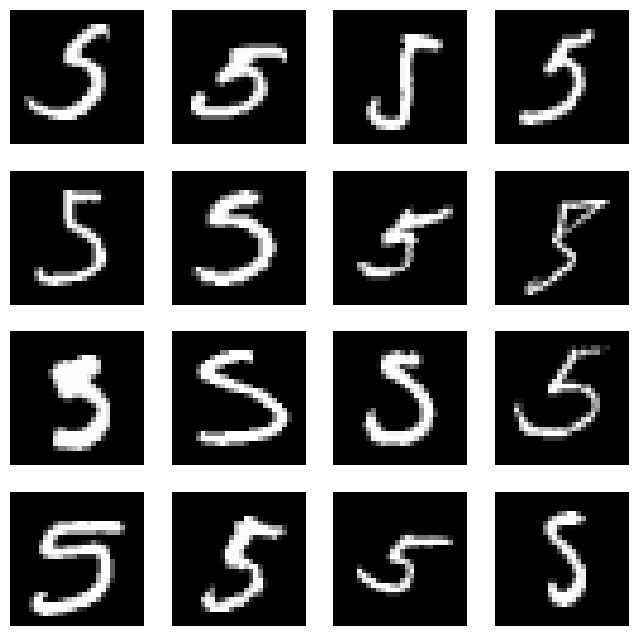

In [14]:
true_5s_idx = np.where(val_y == 5)[0]
pred_3s_idx = np.where(pred_y == 3)[0]

# find the intersection
true_5s_pred_as_3s_idx = np.intersect1d(true_5s_idx, pred_3s_idx)

num_to_plot = 16
assert num_to_plot < true_5s_pred_as_3s_idx.shape[0]

# let's print the first 'num_to_plot'
first_16_x = val_x[true_5s_pred_as_3s_idx[0:num_to_plot]]
plots.plot_images(first_16_x.reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(8,8))

In [15]:
from sklearn.decomposition import PCA, KernelPCA

k = 49
pca_decomp = PCA(n_components=k, whiten=True).fit(train_x)
all_x_pca = pca_decomp.transform(all_x)

In [16]:
explained_var = np.sum(pca_decomp.explained_variance_ratio_)
print('Explained variance (k={}): {: .1f}%'.format(k, explained_var*100))

Explained variance (k=49):  82.2%


In [17]:
print(all_x_pca.shape)

(70000, 49)


In [18]:
# resplit
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(all_x_pca, all_y, prop_vec, shuffle=True, seed=seed)

In [19]:
# what does the data look like now?
train_x[0]

array([ 0.67320532, -0.51052086,  1.43840686,  0.79587162, -0.78123137,
       -0.87686966,  0.25996501,  0.22128569,  2.37334357,  0.51957482,
       -0.25722458, -0.09842539, -1.03288306,  0.10559647, -1.38249371,
        2.07910633, -0.97693137, -1.25311042,  1.04933739,  1.80570564,
       -1.22798947,  0.57603433, -0.5061654 , -0.48930222, -2.10376971,
        1.07524586, -1.41927975,  0.51783344,  1.90329476, -0.18795771,
        0.52169286, -1.34522187, -3.10265709, -0.91152062, -2.13453583,
        0.57587536,  1.80167364, -0.60631136,  0.80961988, -1.27596721,
        0.1613285 , -0.34976471, -0.67963187,  1.24284469,  0.18031951,
        0.84870204,  0.68792648, -4.03793728,  0.54865575])

### Let's plot the PCA transformed data as though they are images

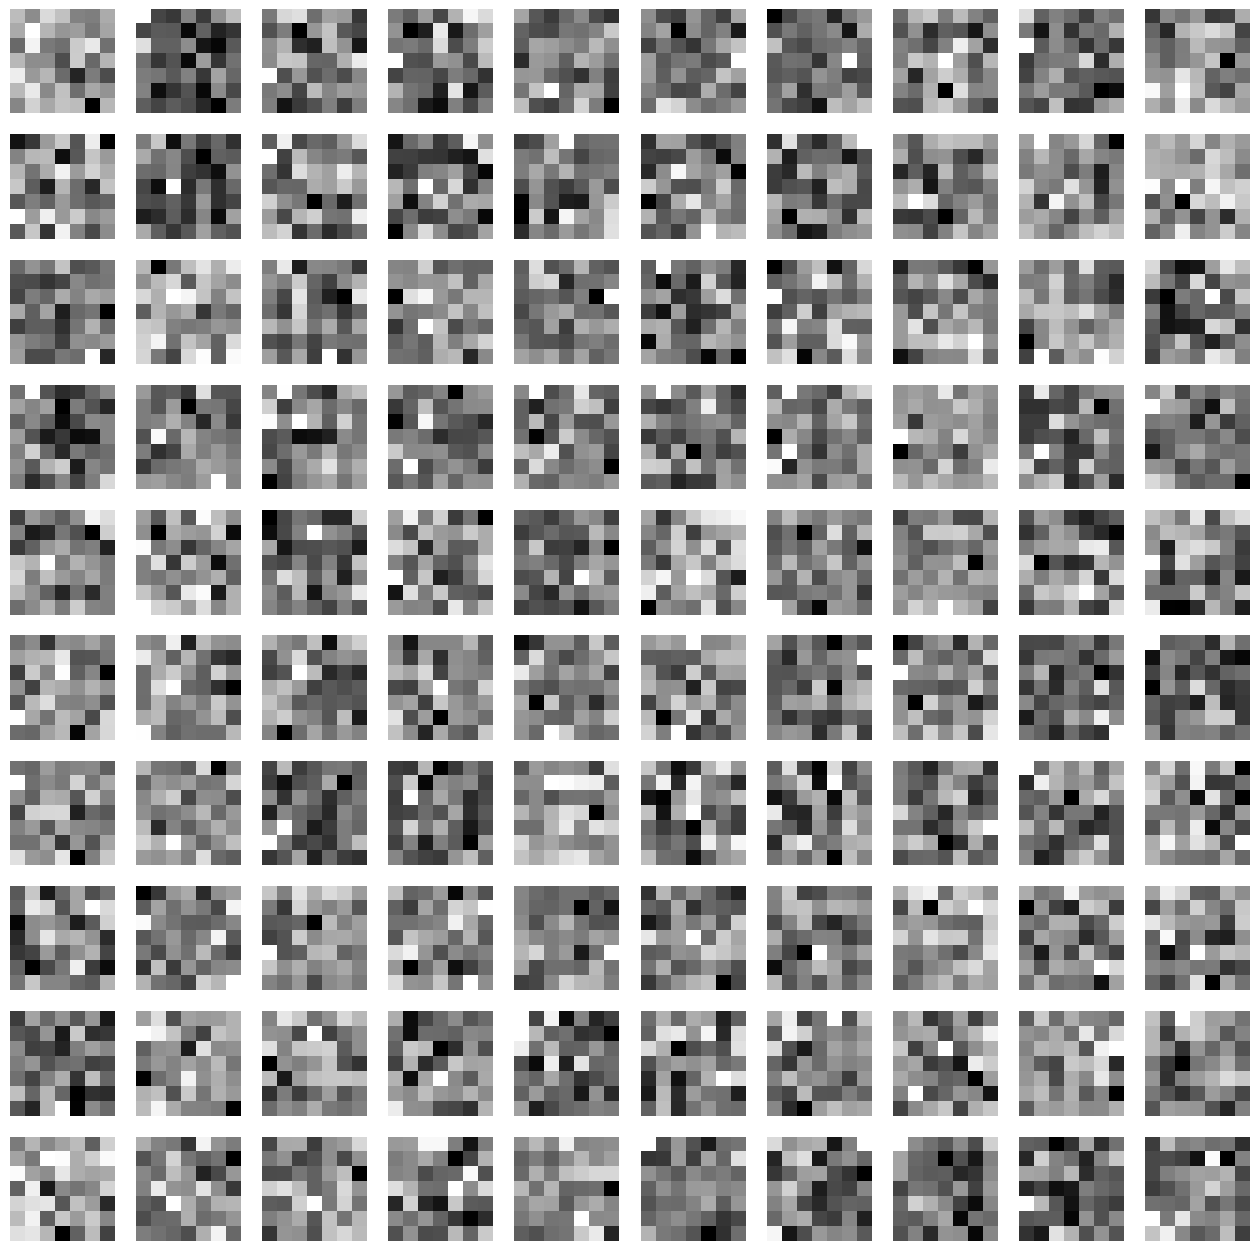

In [20]:
sqrtk = int(np.sqrt(k))
plots.plot_images(train_x[0:100].reshape(-1, sqrtk, sqrtk), dim_x=sqrtk, dim_y=sqrtk, fig_size=(16,16))

### Now let's inverse the PCA transform and see what we get.

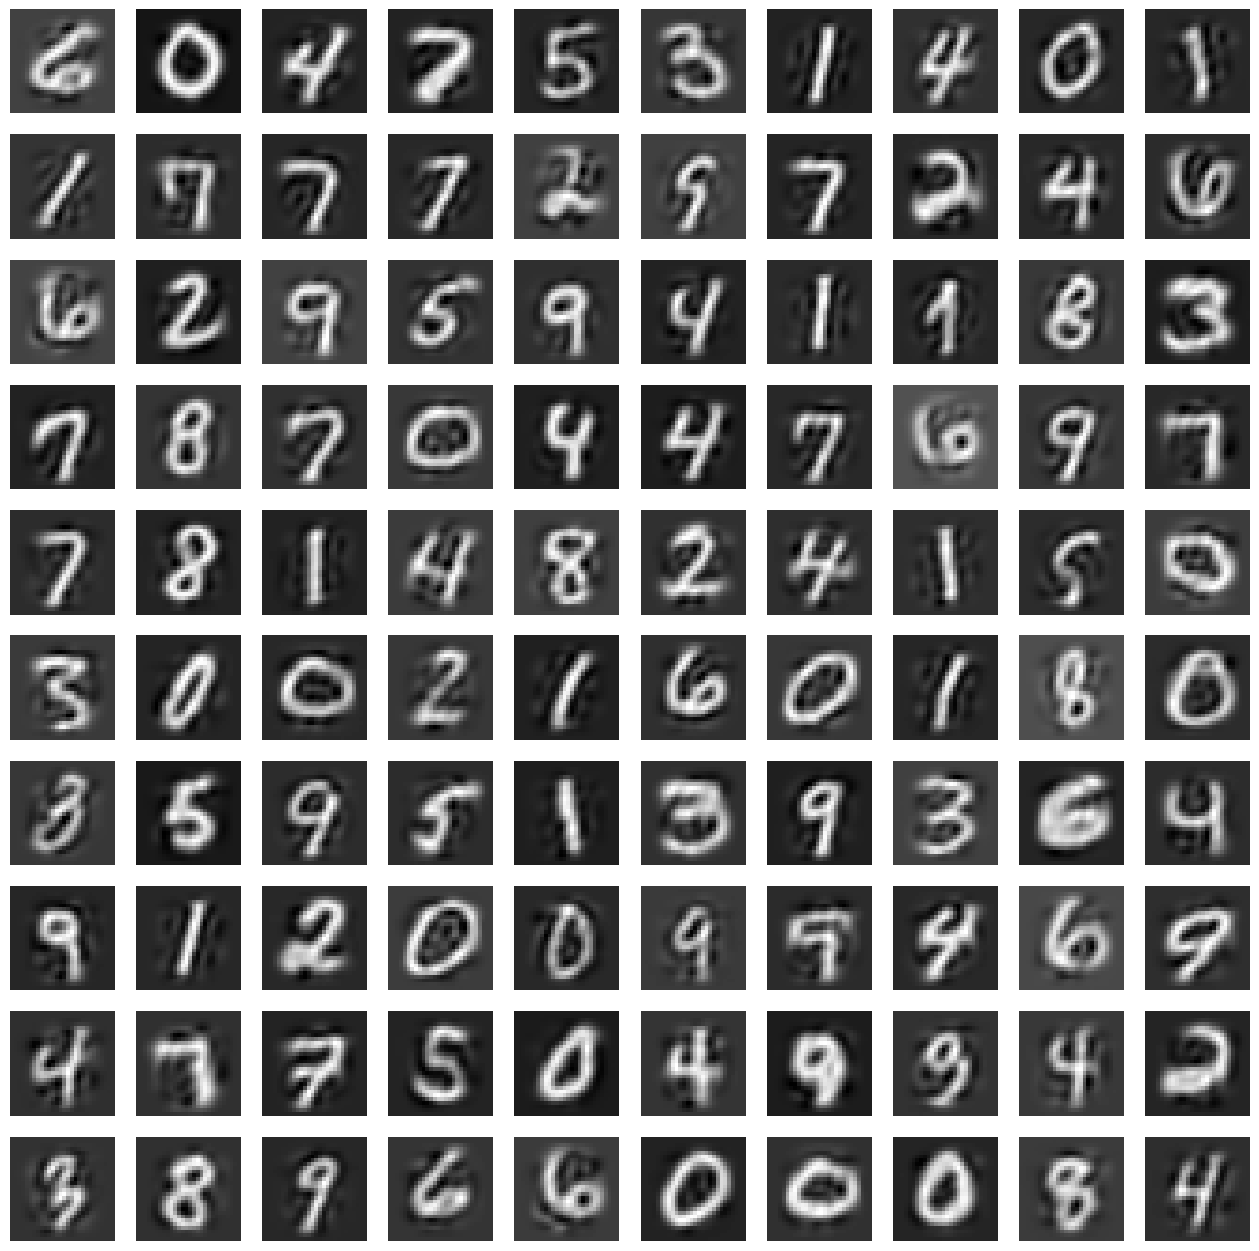

In [21]:
inv_tr100 = pca_decomp.inverse_transform(train_x[0:100])
plots.plot_images(inv_tr100.reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(16,16))

## Let's train a model on the PCA transformed data

In [22]:
model = LogisticRegression(max_iter=500).fit(train_x, train_y)

In [23]:
# Classification report

pred_y  = model.predict(val_x)
print(classification_report(val_y, pred_y, digits=2))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       507
           1       0.94      0.96      0.95       596
           2       0.91      0.87      0.89       491
           3       0.89      0.89      0.89       525
           4       0.90      0.92      0.91       463
           5       0.88      0.84      0.86       446
           6       0.91      0.96      0.94       475
           7       0.91      0.93      0.92       528
           8       0.87      0.85      0.86       494
           9       0.86      0.84      0.85       475

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

